In [18]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import HopFinder
import HOP
import LC
import LC_Set
from fermi_catalog import select_bll, select_fsrq, select_bcu

# COSI Analysis

## Daily

In [133]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [160]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 22 #Counts / s


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        background_counts = COSI_bkg_rate * duration
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration,background_counts]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts)
    
    return mdp99

In [158]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]/100

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]
        background_counts = flarestack[:,3]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration,background_counts]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_daily_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_daily_df.columns=['Name','Photon Counts','Duration (s)','Background Counts']

COSI_BAND_ALL_daily_df


0
9.96e-07 6.39e-09 9.8961e-07 9.896100000000001e-08 1.05351e-07
<class 'list'>
 
[['0' '0' '0' '0']
 ['4FGL J0538.8-4405' '8.01767808' '25531200.0' '561686400.0']
 ['4FGL J0538.8-4405' '32.26073184' '81388800.0' '1790553600.0']
 ['4FGL J0538.8-4405' '9.00528192' '56246400.0' '1237420800.0']
 ['4FGL J0538.8-4405' '1.94819904' '16848000.0' '370656000.0']
 ['4FGL J0538.8-4405' '0.98467488' '8035200.0' '176774400.0']
 ['4FGL J0538.8-4405' '2.6540265599999997' '22939200.0' '504662400.0']
 ['4FGL J0538.8-4405' '1.4440291200000002' '14644800.0' '322185600.0']
 ['4FGL J0538.8-4405' '2.1941020799999995' '10238400.0' '225244800.0']
 ['4FGL J0538.8-4405' '8.858471040000001' '47952000.0' '1054944000.0']
 ['4FGL J0538.8-4405' '0.53034912' '3888000.0' '85536000.0']
 ['4FGL J0538.8-4405' '1.5995232' '8812800.0' '193881600.0']
 ['4FGL J0538.8-4405' '9.3453264' '38620800.0' '849657600.0']]
aaaaaaa
[  0.         150.20711668 604.38838569 168.70937179  36.4985171
  18.44738254  49.72183632  27.05315035 

,Name,Photon Counts,Duration (s),Background Counts
0,0,0,0,0
1,0,0.0,0,0
2,4FGL J0538.8-4405,150.20711668253008,25531200.0,561686400.0
3,4FGL J0538.8-4405,604.388385690174,81388800.0,1790553600.0
4,4FGL J0538.8-4405,168.70937179315118,56246400.0,1237420800.0
...,...,...,...,...
735,4FGL J0428.6-3756,0.3445793415740104,518400.0,11404800.0
736,4FGL J0428.6-3756,7.202721707548504,7516800.0,165369600.0
737,4FGL J0428.6-3756,6.56052040526204,7257600.0,159667200.0
738,4FGL J0428.6-3756,2.5556301166739104,3888000.0,85536000.0


In [ ]:
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df['Photon Counts']= COSI_BAND_ALL_daily_df['Photon Counts'].astype(float)
COSI_BAND_ALL_daily_df['Duration (days)'] = COSI_BAND_ALL_daily_df['Duration (s)'].astype(float)/(86400)
COSI_BAND_ALL_daily_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Counts'],COSI)


#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
COSI_BAND_ALL_daily_df

,Name,Photon Counts,Duration (s),Background Counts,Duration (days)
0,4FGL J0538.8-4405,150.207117,25531200.0,561686400.0,295.5
1,4FGL J0538.8-4405,604.388386,81388800.0,1790553600.0,942.0
2,4FGL J0538.8-4405,168.709372,56246400.0,1237420800.0,651.0
3,4FGL J0538.8-4405,36.498517,16848000.0,370656000.0,195.0
4,4FGL J0538.8-4405,18.447383,8035200.0,176774400.0,93.0
...,...,...,...,...,...
578,4FGL J0428.6-3756,0.344579,518400.0,11404800.0,6.0
579,4FGL J0428.6-3756,7.202722,7516800.0,165369600.0,87.0
580,4FGL J0428.6-3756,6.560520,7257600.0,159667200.0,84.0
581,4FGL J0428.6-3756,2.555630,3888000.0,85536000.0,45.0


In [137]:
print(COSI_BAND_ALL_daily_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


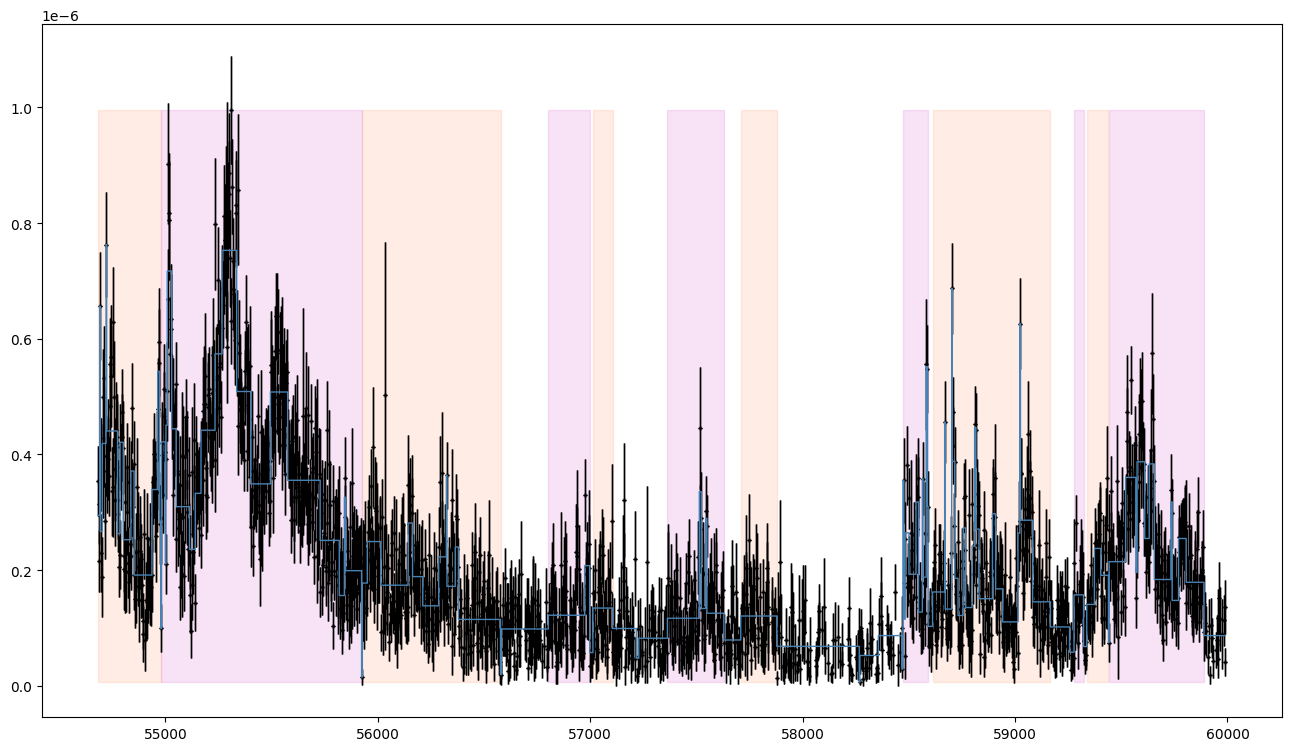

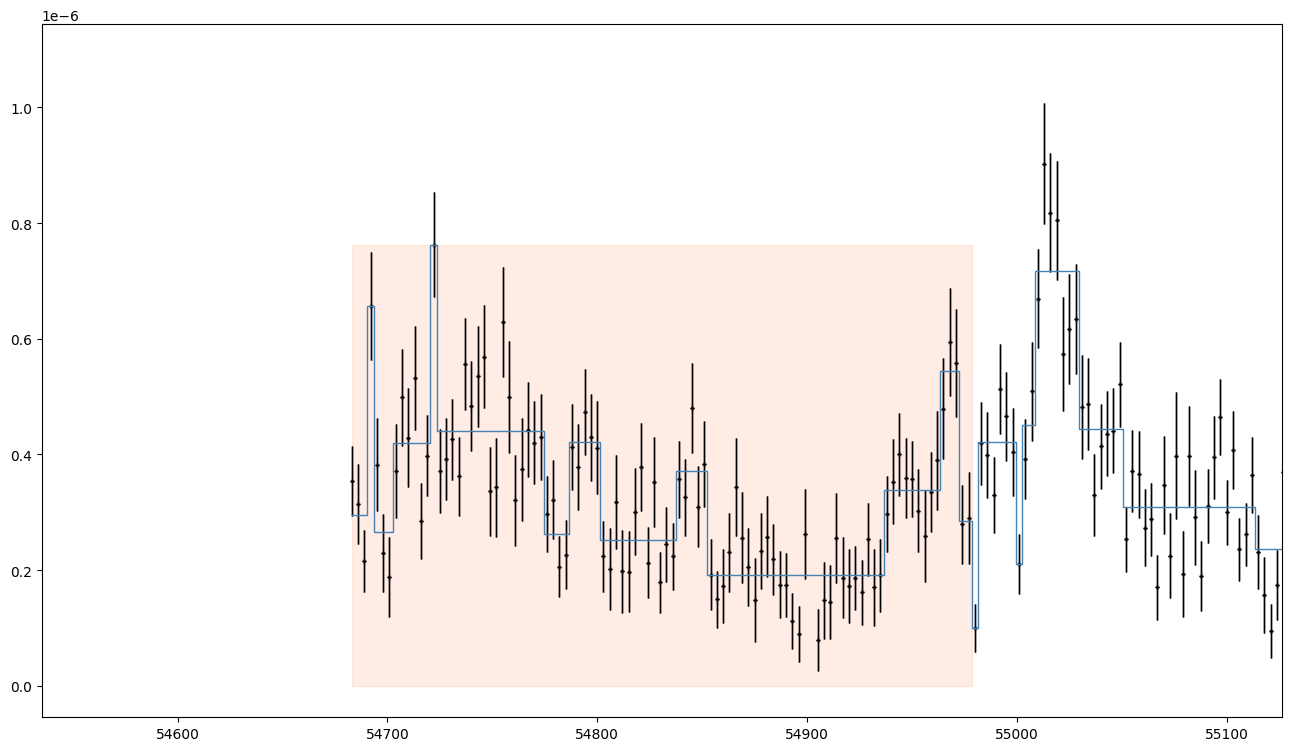

In [138]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [139]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3.  1.  3.  6.  1. 17.  4.  5. 12.  5. 27.  9.  3.  2.  1.  6.  1.  2.
  7.  7. 21.  9.  9. 22. 11. 23. 22. 31. 27. 50. 30.  8.  2. 25.  1.  8.
 21. 42.  7. 14. 22. 12.  1. 13.  5. 59.  1. 61. 50.  8.  5. 29. 30.  3.
 32. 45.  3.  6.  2. 22. 22. 47. 62.  1. 19. 16.  1.  1.  2.  5. 11.  4.
  6.  1.  5.  2.  1.  7. 19.  1.  9.  1.  4.  5.  8.  4. 10.  4.  2.  5.
 21.  5. 11. 24.  3.  1. 19. 26. 26.  5. 14.  5. 12. 10. 12.  1. 26. 16.
  2. 12.  7.  8. 26.  2. 10. 12. 28. 19.]


In [140]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54684.50001157, 54687.50001157, 54690.50001157, 54693.50001157,
       54696.50001157, 54699.50001157, 54702.50001157, 54705.50001157,
       54708.50001157, 54711.50001157, 54714.50001157, 54717.50001157,
       54720.50001157, 54723.50001157, 54726.50001157, 54729.50001157,
       54732.50001157, 54735.50001157, 54738.50001157, 54741.50001157,
       54744.50001157, 54747.50001157, 54750.50001157, 54753.50001157,
       54756.50001157, 54759.50001157, 54762.50001157, 54765.50001157,
       54768.50001157, 54771.50001157, 54774.50001157, 54777.50001157,
       54780.50001157, 54783.50001157, 54786.50001157, 54789.50001157,
       54792.50001157, 54795.50001157, 54798.50001157, 54801.50001157,
       54804.50001157, 54807.50001157, 54810.50001157, 54813.50001157,
       54816.50001157, 54819.50001157, 54822.50001157, 54825.50001157,
       54828.50001157, 54831.50001157, 54834.50001157, 54837.50001157,
       54840.50001157, 54843.50001157, 54846.50001157, 54849.50001157,
      

## Weekly

In [2]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [255]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.01


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    fsrq_names = select_fsrq()['Source_Name']
    bll_names = select_bll()['Source_Name']
    bcu_names = select_bcu()['Source_Name']
    flarestack=[0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum)
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp)
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts) * 100
    
    return mdp99

Quiescent Background: 7.893394088669952e-08, Error: 2.5702845037690407e-09


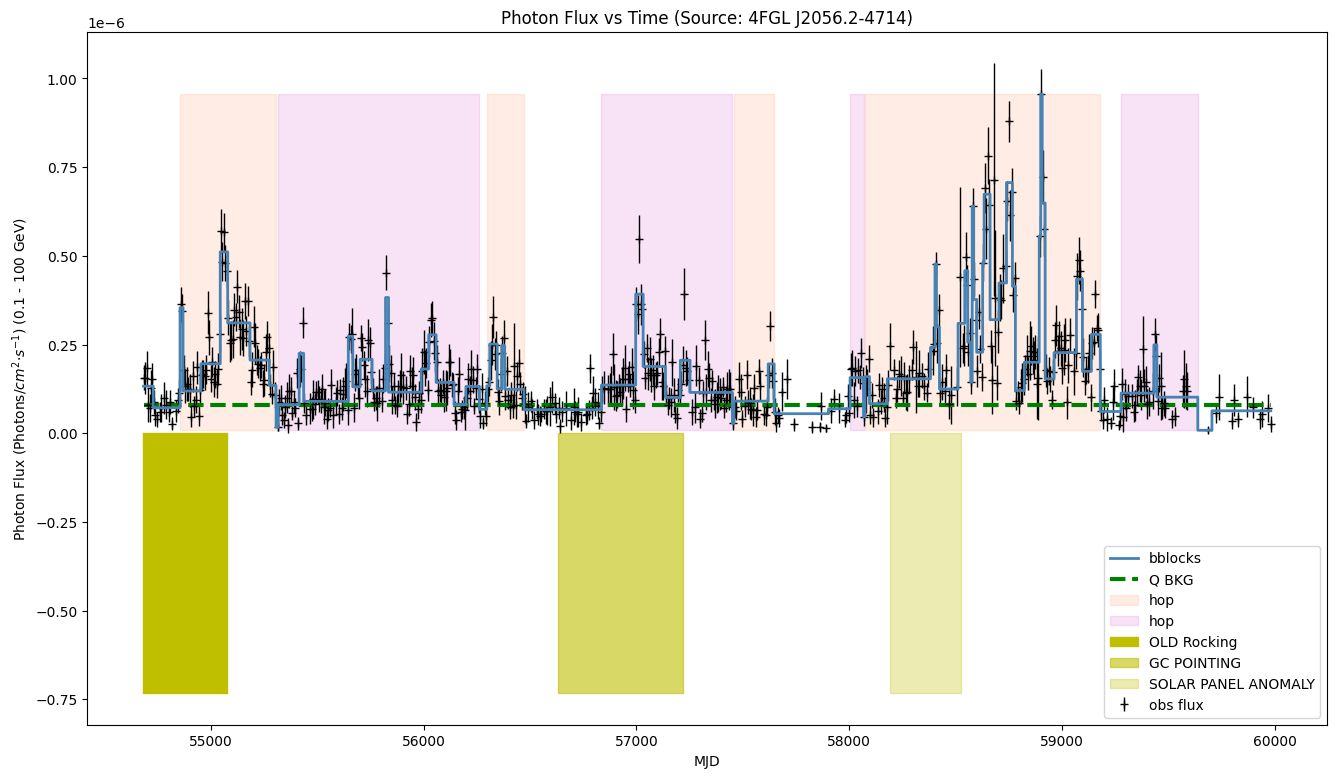

In [328]:
quiescent_flare_plot(cadence_df,sourcename='4FGL J2056.2-4714')

In [256]:

table = 'COSI_LAT_only_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]
    #
    #if sourcename == '4FGL J1036.3-5833e':
    #    continue
    #if sourcename == '4FGL J1855.9+0121e':
    #    continue
    #if sourcename == '4FGL J1923.2+1408e':
    #    continue

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
        flareflux = flarestack[:,1].astype(float)*factor
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,3]
        background_counts = flarestack[:,4]
        starttime_s = flarestack[:,5]
        starttime_mjd = flarestack[:,6]
        fraction_time = flarestack[:,7]
        blazartype = flarestack[:,8]

        COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class']

COSI_BAND_BAT_weekly_df


0
8.94e-07 2.18e-09 8.9182e-07 8.918200000000001e-08 9.136200000000001e-08
<class 'list'>
-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
 
[['0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['4FGL J0001.5+2113' '2.0392000000000003e-06' '1.23330816' '49291200.0'
  '492912.0' '4769971201.0' '55208.00001157408' '0.10998650472334683'
  'FSRQ']
 ['4FGL J0001.5+2113' '3.9017e-06' '2.35974816' '83462400.0' '834624.0'
  '4823798401.0' '55831.00001157408' '0.1862348178137652' 'FSRQ']
 ['4FGL J0001.5+2113' '1.61e-07' '0.0973728' '1209600.0' '12096.0'
  '4908772801.0' '56814.50001157408' '0.002699055330634278' 'FSRQ']
 ['4FGL J0001.5+2113' '2.8699999999999996e-07' '0.1735776' '9676800.0'
  '96768.0' '4913611201.0' '56870.50001157408' '0.021592442645074223'
  'FSRQ']

,Name,Photon Flux (ph/cm2/s),Photon Count,Duration (s),Background Counts,Start Time (s),Start Time (MJD),Fraction of Observation Time,Class
0,0,0,0,0,0,0,0,0,0
1,0,0.0,0.0,0,0,0,0,0,0
2,4FGL J0001.5+2113,1.1584993365505876e-06,50.032552548697495,49291200.0,492912.0,4769971201.0,55208.00001157408,0.10998650472334683,FSRQ
3,4FGL J0001.5+2113,2.2166128194485227e-06,95.72970296157955,83462400.0,834624.0,4823798401.0,55831.00001157408,0.1862348178137652,FSRQ
4,4FGL J0001.5+2113,9.14664540921168e-08,3.95019662629477,1209600.0,12096.0,4908772801.0,56814.50001157408,0.002699055330634278,FSRQ
...,...,...,...,...,...,...,...,...,...
3740,4FGL J2348.0-1630,1.8726943144396889e-06,88.34970140331991,7862400.0,78624.0,5164603201.0,59775.50001157408,0.017173051519154558,FSRQ
3741,0,0.0,0.0,0,0,0,0,0,0
3742,4FGL J2348.1-4934,2.8916634719251386e-11,0.0007474470627784979,437875200.0,4378752.0,4725216001.0,54690.00001157408,1.0,BCU
3743,0,0.0,0.0,0,0,0,0,0,0


In [257]:
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df['Photon Count']= COSI_BAND_BAT_weekly_df['Photon Count'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (weeks)'] = COSI_BAND_BAT_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_BAT_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Photon Count'].astype(float),COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_BAT_weekly_df['Duration (s)']
COSI_BAND_BAT_weekly_df['Fraction of Observation Time'] = COSI_BAND_BAT_weekly_df['Fraction of Observation Time'].astype(float)



pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)','Fraction of Observation Time', 'MDP99','Start Time (MJD)', 'Start Time (s)']
#pd.set_option('display.max_rows',None)
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder]
#COSI_BAND_ALL_weekly_df[neworder].to_csv('COSI_BAND_ALL_weekly_Rbkg%.2f.csv'%COSI_bkg_rate)


,Name,Class,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),Fraction of Observation Time,MDP99,Start Time (MJD),Start Time (s)
0,4FGL J0001.5+2113,FSRQ,1.158499e-06,57.103822,50.032553,492912.0,49291200.0,81.5,0.109987,2.006735e+04,55208.00001157408,4769971201.0
1,4FGL J0001.5+2113,FSRQ,2.216613e-06,185.003826,95.729703,834624.0,83462400.0,138.0,0.186235,1.364771e+04,55831.00001157408,4823798401.0
2,4FGL J0001.5+2113,FSRQ,9.146645e-08,0.110638,3.950197,12096.0,1209600.0,2.0,0.002699,3.982072e+04,56814.50001157408,4908772801.0
3,4FGL J0001.5+2113,FSRQ,1.630489e-07,1.577792,7.041655,96768.0,9676800.0,16.0,0.021592,6.317467e+04,56870.50001157408,4913611201.0
4,4FGL J0001.5+2113,FSRQ,4.460154e-06,106.551301,192.622383,238896.0,23889600.0,39.5,0.053306,3.630018e+03,57280.00001157408,4948992001.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2830,4FGL J2348.0-1630,FSRQ,2.677695e-06,55.061973,126.327896,205632.0,20563200.0,34.0,0.044914,5.134705e+03,59418.50001157408,5133758401.0
2831,4FGL J2348.0-1630,FSRQ,1.066690e-06,7.096476,50.324152,66528.0,6652800.0,11.0,0.014531,7.332060e+03,59670.50001157408,5155531201.0
2832,4FGL J2348.0-1630,FSRQ,1.872694e-06,14.723872,88.349701,78624.0,7862400.0,13.0,0.017173,4.541009e+03,59775.50001157408,5164603201.0
2833,4FGL J2348.1-4934,BCU,2.891663e-11,0.012662,0.000747,4378752.0,437875200.0,724.0,1.000000,4.003416e+09,54690.00001157408,4725216001.0


In [ ]:
COSI_BAND_ALL_weekly_df = COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df[:]['Photon Count']!='0'].reset_index(drop=True)
COSI_BAND_ALL_weekly_df = COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_weekly_df['Photon Count']= COSI_BAND_ALL_weekly_df['Photon Count'].astype(float)
COSI_BAND_ALL_weekly_df['Duration (s)'] = COSI_BAND_ALL_weekly_df['Duration (s)'].astype(float)
COSI_BAND_ALL_weekly_df['Duration (weeks)'] = COSI_BAND_ALL_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_ALL_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Count'].astype(float),COSI_BAND_ALL_weekly_df['Background Counts'].astype(float))
COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_ALL_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_ALL_weekly_df['Duration (s)']



pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')
COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)', 'MDP99','Start Time (MJD)', 'Start Time (s)']
#pd.set_option('display.max_rows',None)
COSI_BAND_ALL_weekly_df[neworder]
COSI_BAND_ALL_weekly_df[neworder]
#COSI_BAND_ALL_weekly_df[neworder].to_csv('COSI_BAND_ALL_weekly_Rbkg%.2f.csv'%COSI_bkg_rate)


,Name,Class,Photon Flux (ph/cm2/s),Fluence (ph/cm2),Photon Count,Background Counts,Duration (s),Duration (weeks),MDP99,Start Time (MJD),Start Time (s)
0,4FGL J0538.8-4405,BLL,7.456987e-09,1.098182,0.298816,1472688.0,147268800.0,243.5,5.807486e+06,54683.00001157408,4724611201.0
1,4FGL J0538.8-4405,BLL,1.767891e-10,0.001711,0.007084,96768.0,9676800.0,16.0,6.279233e+07,56415.50001157408,4874299201.0
2,4FGL J0538.8-4405,BLL,4.760877e-10,0.012669,0.019078,266112.0,26611200.0,44.0,3.866708e+07,56800.50001157408,4907563201.0
3,4FGL J0538.8-4405,BLL,6.913004e-11,0.000293,0.002770,42336.0,4233600.0,7.0,1.062146e+08,57444.50001157408,4963204801.0
4,4FGL J0538.8-4405,BLL,5.340248e-10,0.018571,0.021399,347760.0,34776000.0,57.5,3.940710e+07,57500.50001157408,4968043201.0
...,...,...,...,...,...,...,...,...,...,...,...
463,4FGL J0428.6-3756,BLL,6.314701e-08,0.210052,3.047975,33264.0,3326400.0,5.5,8.557200e+04,58298.50001157408,5036990401.0
464,4FGL J0428.6-3756,BLL,5.330748e-07,10.961723,25.730415,205632.0,20563200.0,34.0,2.520355e+04,58599.50001157408,5062996801.0
465,4FGL J0428.6-3756,BLL,5.920629e-07,11.816628,28.577650,199584.0,19958400.0,33.0,2.235648e+04,58942.50001157408,5092632001.0
466,4FGL J0428.6-3756,BLL,2.934543e-07,3.194661,14.164431,108864.0,10886400.0,18.0,3.331251e+04,59271.50001157408,5121057601.0


,Name,Photon Flux (ph/cm2/s),Photon Count,Duration (s),Background Counts,Start Time (s),Start Time (MJD),Class,Duration (weeks),MDP99,Fluence (ph/cm2)
295,4FGL J0522.9-3628,1.179171e-06,59.077463,7862400.0,78624.0,4727332801.0,54714.50001157408,None,13.0,6789.766918,9.271112e+00
296,4FGL J0522.9-3628,1.184703e-06,59.354624,6955200.0,69552.0,4736404801.0,54819.50001157408,None,11.5,6356.550747,8.239845e+00
297,4FGL J0522.9-3628,3.630234e-06,181.877849,16329600.0,163296.0,4755153601.0,55036.50001157408,None,27.0,3178.964828,5.928027e+01
298,4FGL J0522.9-3628,8.513360e-06,426.526633,25401600.0,254016.0,4775112001.0,55267.50001157408,None,42.0,1691.160134,2.162530e+02
299,4FGL J0522.9-3628,3.530898e-06,176.901002,9072000.0,90720.0,4801723201.0,55575.50001157408,None,15.0,2437.138903,3.203230e+01
300,4FGL J0522.9-3628,1.481702e-05,742.345535,52920000.0,529200.0,4811400001.0,55687.50001157408,None,87.5,1402.310703,7.841168e+02
301,4FGL J0522.9-3628,1.864064e-07,9.339120,1209600.0,12096.0,4866436801.0,56324.50001157408,None,2.0,16846.844877,2.254772e-01
302,4FGL J0522.9-3628,2.226053e-06,111.527165,8467200.0,84672.0,4871275201.0,56380.50001157408,None,14.0,3733.456678,1.884844e+01
303,4FGL J0522.9-3628,4.124993e-07,20.666568,2419200.0,24192.0,4882766401.0,56513.50001157408,None,4.0,10766.858008,9.979183e-01
304,4FGL J0522.9-3628,9.103847e-07,45.611055,7862400.0,78624.0,4901817601.0,56734.00001157408,None,13.0,8793.654878,7.157809e+00


Text(0, 0.5, 'Number of Sources')

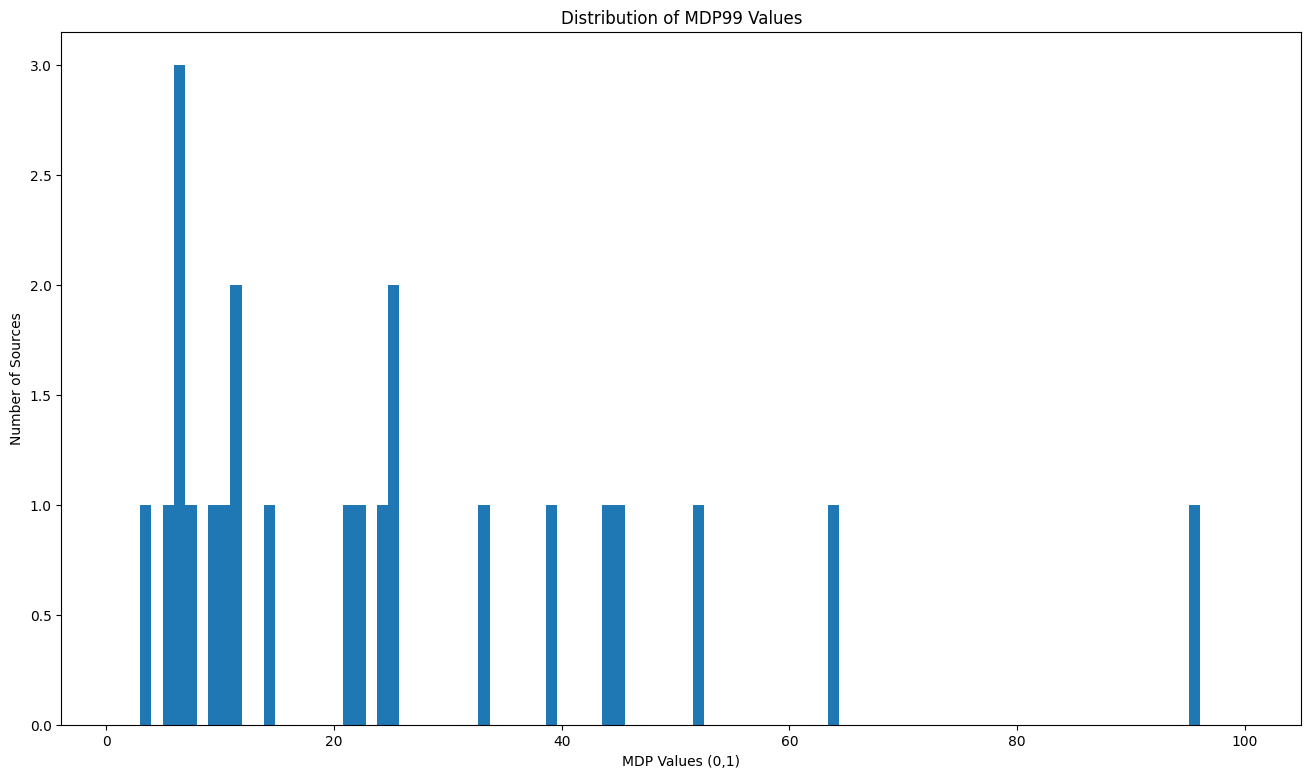

In [ ]:
#COSI_BAND_ALL_weekly_df.to_csv('COSI_BAND_ALL_weekly_0bkg.csv')
plt.figure(figsize=(16,9))
plt.hist(COSI_BAND_ALL_weekly_df['MDP99'],bins=100,range=(1,100))
plt.title('Distribution of MDP99 Values')
plt.xlabel('MDP Values (0,1)')
plt.ylabel('Number of Sources')

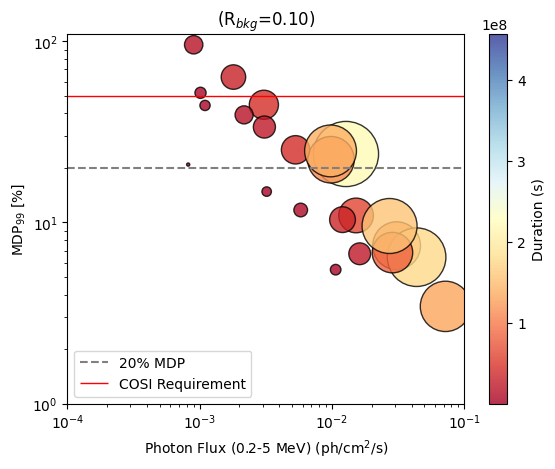

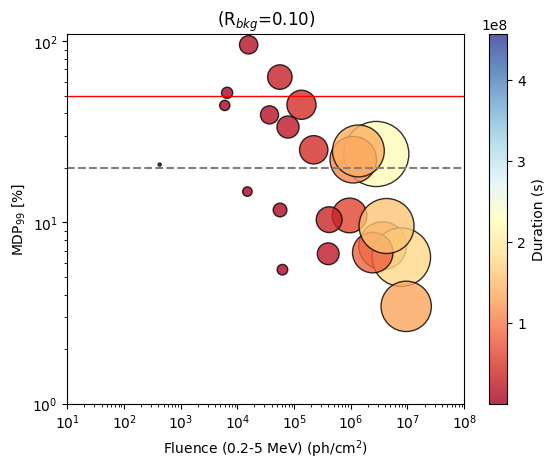

In [ ]:
#plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'])
plt.figure()
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_ALL_weekly_df['Duration (s)']
sc = plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'],c=z, s=COSI_BAND_ALL_weekly_df['Duration (s)']*1e-5, cmap=cm,alpha = 0.8,edgecolors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Duration (s)')
plt.ylim(1,110)
plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f)'%COSI_bkg_rate)
plt.legend(loc=3)
plt.savefig('Diagrams/COSI_Flux_v_MDP99_Rbkg%.2f.png'%COSI_bkg_rate, dpi=200)


plt.figure()
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_ALL_weekly_df['Duration (s)']
sc = plt.scatter(COSI_BAND_ALL_weekly_df['Fluence (ph/cm2)'],COSI_BAND_ALL_weekly_df['MDP99'],c=z, s=COSI_BAND_ALL_weekly_df['Duration (s)']*1e-5, cmap=cm, alpha =0.8,edgecolors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Duration (s)')
plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,10,1e+8,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.title(r'(R$_{bkg}$=%.2f)'%COSI_bkg_rate)
plt.ylim(1,110)
plt.xlim(10,1e+8)
plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.savefig('Diagrams/COSI_Fluence_v_MDP99_Rbkg%.2f.png'%COSI_bkg_rate, dpi=200)

In [ ]:
COSI_LAT_Sources[COSI_LAT_Sources['Name']='4FGL J2253.9+1609'

,Name,ph/s_ratio,Aeff_mean(cm2)
0,4FGL J2253.9+1609,0.343804,5449.182919
1,4FGL J2253.9+1609,1.202340,5913.637940
2,4FGL J2253.9+1609,0.426944,5964.610300
3,4FGL J2253.9+1609,0.000527,6993.495144
4,4FGL J2253.9+1609,0.009530,6523.682940
...,...,...,...
60,4FGL J2253.9+1609,1.820678,5533.541922
61,4FGL J2253.9+1609,0.514739,5460.844580
62,4FGL J2253.9+1609,8.482368,5195.910851
63,4FGL J2253.9+1609,0.298478,5247.438973


4FGL J2253.9+1609


<Figure size 1600x900 with 0 Axes>

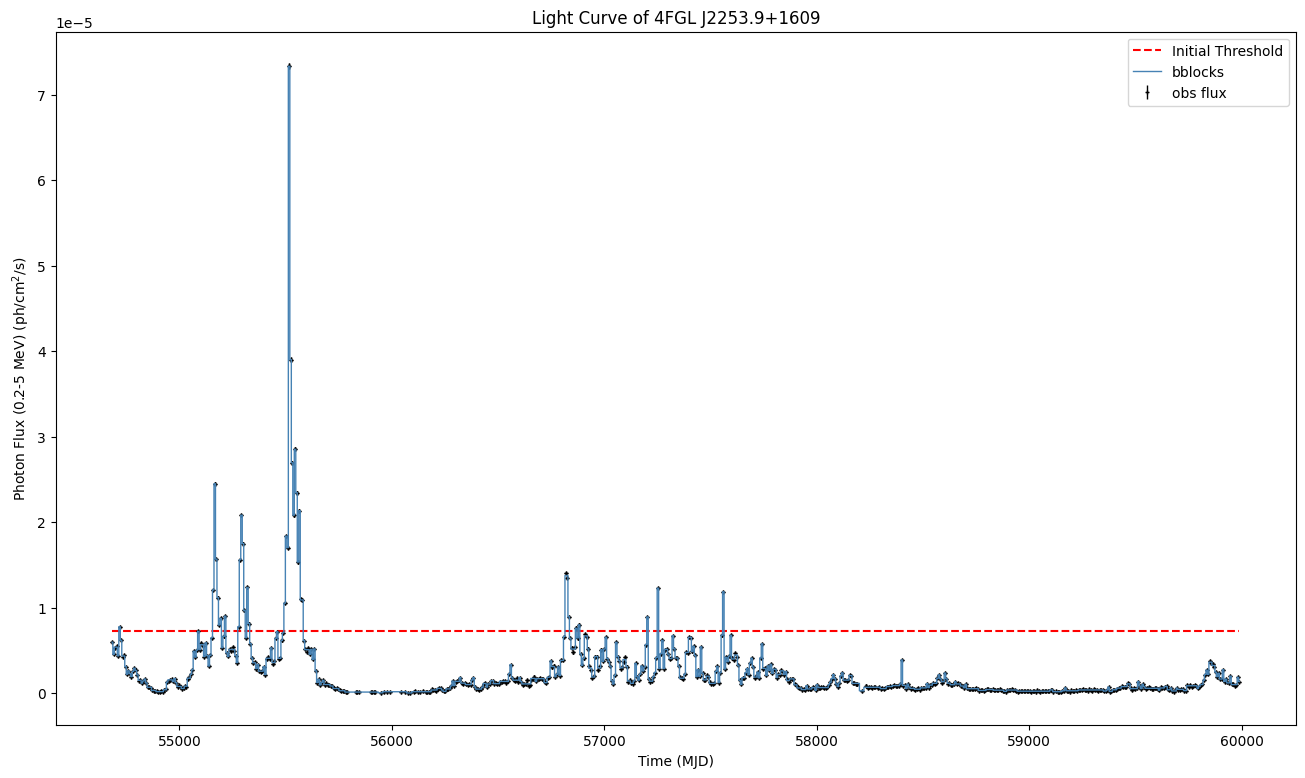

<Figure size 1600x900 with 0 Axes>

In [327]:
p = 2
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = COSI_LAT_Sources['ph/s_ratio'][p]
percent = 0.1
Aeff = 70
sourcename = '4FGL J2253.9+1609'
print(sourcename)
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)


time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
plt.hlines(thresholdflux,xmin=np.min(sourcelightcurve.time),xmax=np.max(sourcelightcurve.time),label='Initial Threshold',colors='red',linestyles='dashed')
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
#sourcelightcurve.plot_hop()
plt.title('Light Curve of ' +str(titlestring))
plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.xlabel('Time (MJD)')
plt.legend()

plt.figure(figsize=(16,9))
#hops_bl = sourcelightcurve.hops
#hops_bl[0].plot_hop()


In [155]:
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
sourcearray
observation_time = np.max(sourcearray['tmax'])-np.min(sourcearray['tmin'])
print(observation_time)

459648000


Quiescent Background: 6.467184782608695e-07, Error: 9.940757805202996e-09


/var/folders/td/mm4slxv90412jt0yh0zz6zgw0000gp/T/ipykernel_58257/1194800148.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


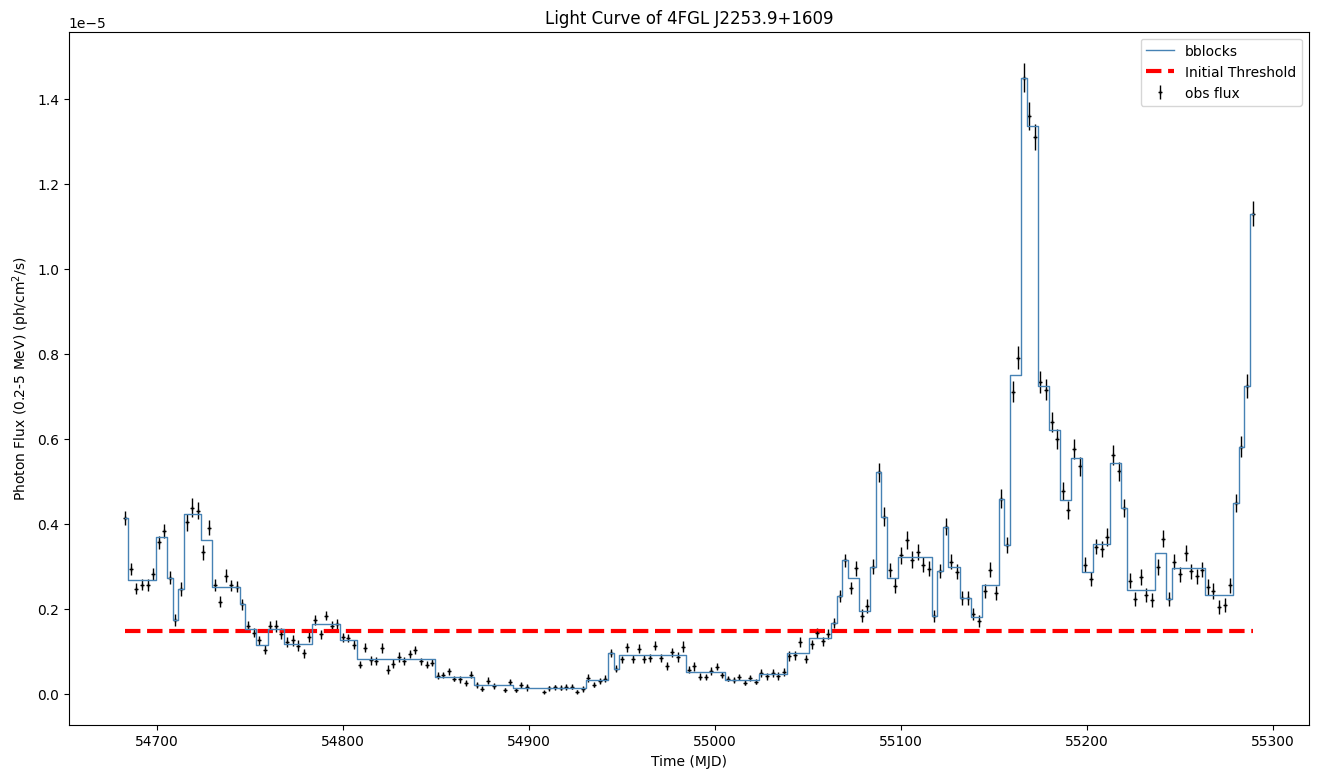

In [ ]:

percent = 0.1 
MJDREFI=51910 
MJDREFF=7.428703703703703e-4
bkg_err = True 
factor = 1
# Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.




sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
sourcearray = sourcearray[0:200]

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

#if sourcelightcurve.hops == None:
#    print("No flares detected for "+str(titlestring))
#    return None


# Finding quiescent background.
quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


# Using quiescent background to find flares again.
sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


#sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
sourcelightcurve.get_bblocks(gamma_value=0.05)
#sourcelightcurve.get_bblocks_above(threshold = 0)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)



# Plotting the Lightcurve itself.
plt.figure(figsize=(16,9))
plt.title('Light Curve of ' +str(titlestring))
plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.xlabel('Time (MJD)')
plt.legend()

sourcelightcurve.plot_bblocks(size=1)
sourcelightcurve.plot_hline(value = thresholdflux, color='red',label='Initial Threshold',lw=3,linestyle = 'dashed')

#if bkg_err == True:
#    y1 = quiescent_background + qui_err
#    y2 = quiescent_background - qui_err
#    plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

#sourcelightcurve.plot_hop()
#plotting_anomalies()
plt.legend()



In [ ]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


In [ ]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      

In [72]:
dutycycle_arr=[0,0]
for i in range(0,len(COSI_BAND_ALL_weekly_df)):
    sourcename = COSI_BAND_ALL_weekly_df['Name'][i]
    flaringtime = np.sum([COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['Name']==sourcename]['Duration (s)']])
    print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    timearray = sourcearray['tmin']/SecsInDay + MJDREFI
    obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    print('obstime is',obstime)
    dutycycle = [sourcename,flaringtime/obstime]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))



339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
4233600.0
obstime is 459043200.0
440899200.0
obstime is 459043200.0
452390400.0
obstime is 459043200.0
417009600.0
obstime is

In [73]:
pd.DataFrame(dutycycle_arr).drop_duplicates(ignore_index=True)

,0,1
0,0,0
1,4FGL J0538.8-4405,0.7404479578392622
2,4FGL J1104.4+3812,0.9268774703557312
3,4FGL J1653.8+3945,0.974308300395257
4,4FGL J0136.5+3906,0.00922266139657444
...,...,...
56,4FGL J0721.9+7120,0.8682476943346509
57,4FGL J2202.7+4216,0.38537549407114624
58,4FGL J2232.6+1143,0.09617918313570488
59,4FGL J1337.6-1257,0.9321475625823452


In [263]:
dutycycle_arr=[0,0,0]
print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
    sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
    if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
        blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
    else:
        blazartype = 'BCU'
    #print(blazartype)
    dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
    print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

    #print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
    #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    #print('obstime is',obstime)
    dutycycle = [sourcename,dutycyclevalue,blazartype]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

741
0    0.109987
1    0.186235
2    0.002699
3    0.021592
4    0.053306
5    0.003374
6    0.016869
7    0.103914
8    0.020243
Name: Fraction of Observation Time, dtype: float64
9    1.0
Name: Fraction of Observation Time, dtype: float64
10    0.085092
Name: Fraction of Observation Time, dtype: float64
11    0.082447
12    0.478723
13    0.033910
14    0.300532
Name: Fraction of Observation Time, dtype: float64
15    0.707398
16    0.277411
Name: Fraction of Observation Time, dtype: float64
17    0.986702
Name: Fraction of Observation Time, dtype: float64
18    0.848545
19    0.035714
20    0.071429
Name: Fraction of Observation Time, dtype: float64
21    0.640559
Name: Fraction of Observation Time, dtype: float64
22    0.413793
23    0.102665
24    0.210031
25    0.076803
Name: Fraction of Observation Time, dtype: float64
26    0.253958
27    0.054749
28    0.079815
29    0.251979
30    0.211082
31    0.045515
Name: Fraction of Observation Time, dtype: float64
32    0.914651
Name: 

In [268]:
pd.DataFrame(dutycycle_arr)==1

,0,1,2
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
737,False,False,False
738,False,False,False
739,False,False,False
740,False,False,False


In [271]:
truthmask = dutycycle_arr[:,1].astype('float64')==1
pd.DataFrame(dutycycle_arr[:,0][truthmask]).drop_duplicates(ignore_index=True)

,0
0,4FGL J0003.3-1928
1,4FGL J0032.3-5522
2,4FGL J0047.0+5657
3,4FGL J0051.2-6242
4,4FGL J0051.5-4220
...,...
73,4FGL J2256.0-2740
74,4FGL J2312.5+7241
75,4FGL J2317.4-4533
76,4FGL J2321.5-1619


In [272]:
errorarray = pd.DataFrame(dutycycle_arr[truthmask][:,0]).drop_duplicates(ignore_index=True)
print(errorarray[0][0])

4FGL J0003.3-1928


In [177]:
i=0
sourcename1 = COSI_BAND_BAT_weekly_df['Name'][i]
if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Class']))>0:
    blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Class'])[-1]
else:
    blazartype = 'BCU'
#print(blazartype)
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)']
flaringtime = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)'])
print(flaringtime)
#print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)']/60/60/24)

#print(flaringtime)
sourcearray = cadence_df[cadence_df['source_name'] == sourcename1].reset_index(drop=True)
observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
#obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
#print('obstime is',obstime)
dutycycle = [sourcename1,flaringtime/obstime,blazartype]
dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))
dutycycle
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)']

232243200.0


0    49291200.0
1    83462400.0
2     1209600.0
3     9676800.0
4    23889600.0
5     1512000.0
6     7560000.0
7    46569600.0
8     9072000.0
Name: Duration (s), dtype: float64

4FGL J0047.0+5657
Quiescent Background: nan, Error: 3.87e-08


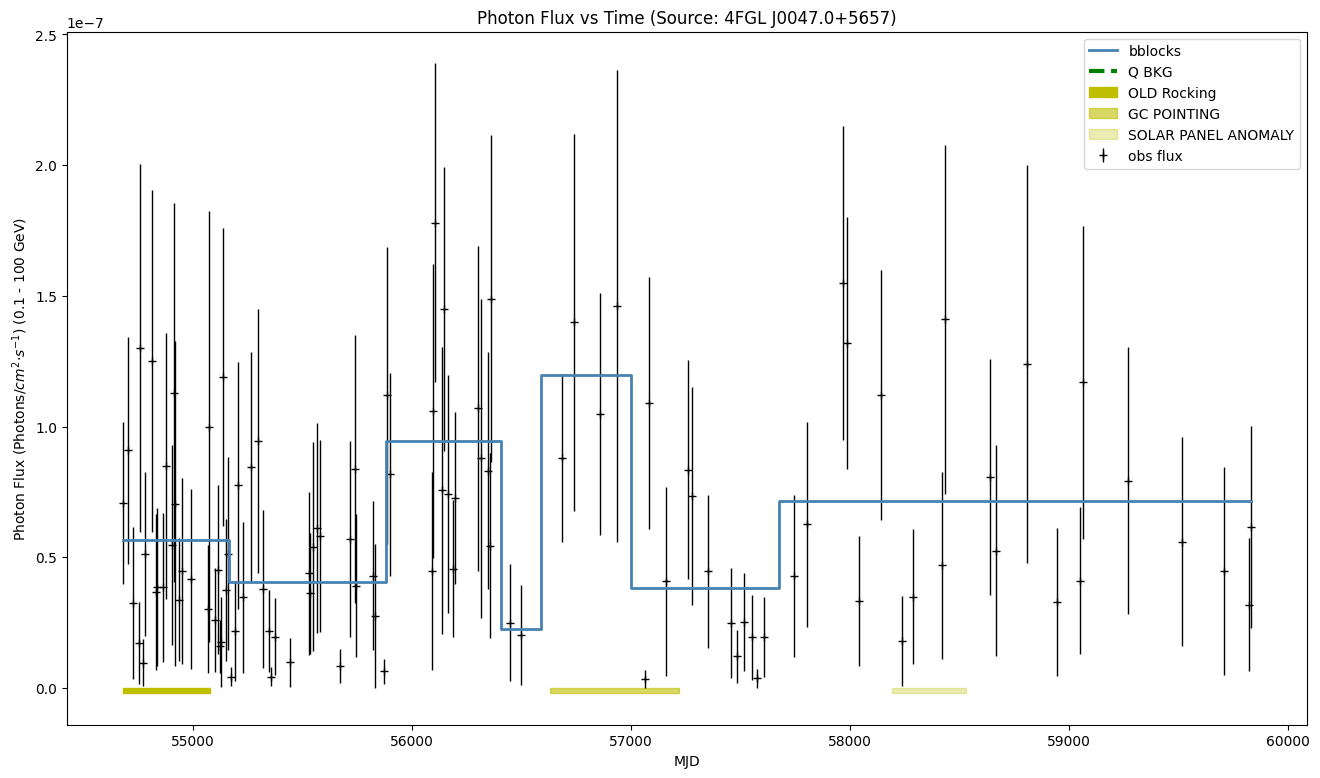

In [326]:
p = 2
jimjomes = errorarray[0][p]
print(jimjomes)
quiescent_flare_plot(sourcename = jimjomes,cadence_df=cadence_df)

#COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==jimjomes]

In [316]:
filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True)

,0,1,2
0,0,0,0
1,4FGL J0534.5+2201s,0.002638522427440633,None
2,4FGL J2052.2-5533,0.008053691275167786,BCU
3,4FGL J0809.5+5341,0.015151515151515152,FSRQ
4,4FGL J1023.1+3949,0.021164021164021163,FSRQ
...,...,...,...
659,4FGL J0811.0-7529,0.9980053191489362,BLL
660,4FGL J0904.5-3513,0.9980211081794195,BCU
661,4FGL J1514.8+4448,0.9986522911051213,None
662,4FGL J0050.4-0452,0.9986577181208054,FSRQ


Text(0.5, 0, 'Duty Cycle Ratio')

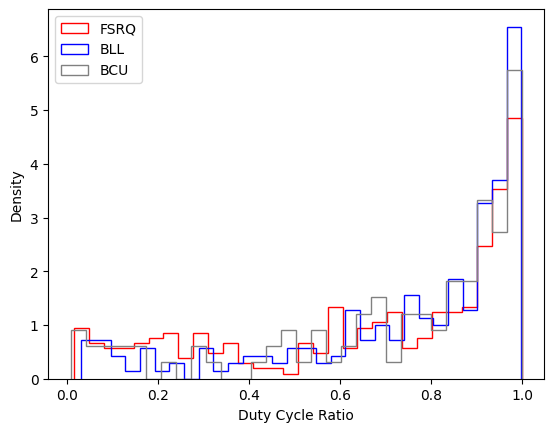

In [283]:
plt.figure()
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),label='FSRQ',bins=30,density=True,histtype='step',color='r')


plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),label='BLL',bins=30,density=True,histtype='step',color='blue')

plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),label='BCU',bins=30,density=True,histtype='step',color='grey')
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
#plt.yscale('log')
#plt.xscale('log')

Quiescent Background: 9.464999999999999e-09, Error: 9.82784536123989e-09


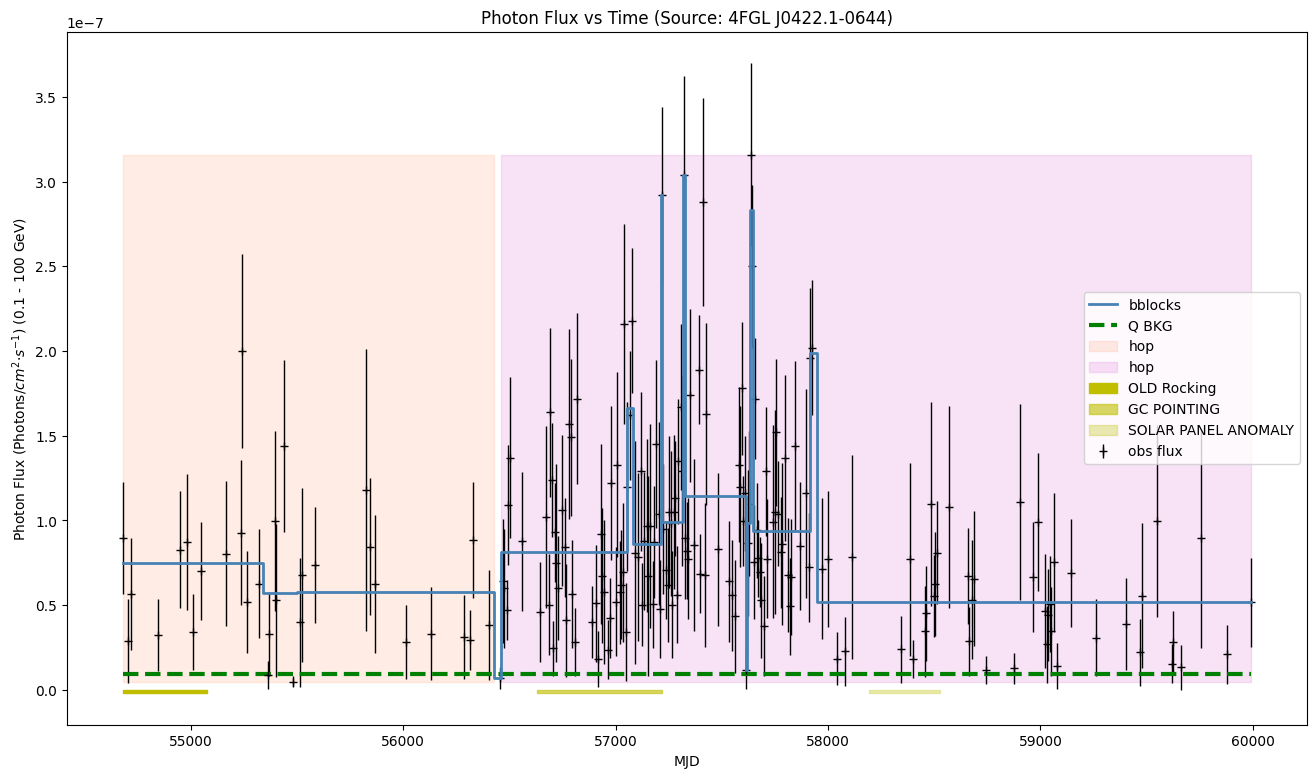

In [322]:
quiescent_flare_plot(sourcename = pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True)[0][630],cadence_df=cadence_df)

In [128]:
dutycycle_df=pd.DataFrame(dutycycle_arr)
dutycycle_df.columns=['Name','Duty Cycle Ratio','Class']
dutycycle_df
dutycycle_df.to_csv('COSI_BAND_ALL_weekly_duty_cycles.csv')


## Monthly

In [106]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'Monthly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [107]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration]))
    return flarestack


0
nan nan nan nan nan


IndexError: index -1 is out of bounds for axis 0 with size 0

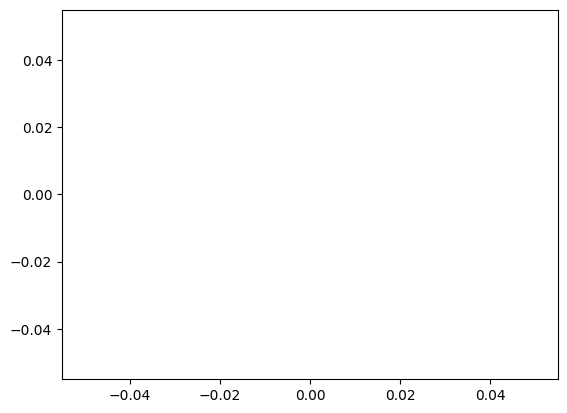

In [ ]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_monthly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_monthly_df.columns=['Name','Photons','Duration (s)']

COSI_BAND_ALL_monthly_df


In [ ]:
COSI_BAND_ALL_monthly_df = COSI_BAND_ALL_monthly_df[COSI_BAND_ALL_monthly_df[:]['Photons']!='0'].reset_index(drop=True)
COSI_BAND_ALL_monthly_df = COSI_BAND_ALL_monthly_df[COSI_BAND_ALL_monthly_df[:]['Photons']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_monthly_df['Photons']= COSI_BAND_ALL_monthly_df['Photons'].astype(float)
COSI_BAND_ALL_monthly_df['Duration (s)'] = COSI_BAND_ALL_monthly_df['Duration (s)'].astype(float)
COSI_BAND_ALL_monthly_df

,Name,Photons,Duration (s)
0,4FGL J0538.8-4405,88244.455393,147268800.0
1,4FGL J0538.8-4405,2092.085690,9676800.0
2,4FGL J0538.8-4405,5633.924218,26611200.0
3,4FGL J0538.8-4405,818.070769,4233600.0
4,4FGL J0538.8-4405,6319.540038,34776000.0
...,...,...,...
463,4FGL J0428.6-3756,182.520074,3326400.0
464,4FGL J0428.6-3756,1540.798913,20563200.0
465,4FGL J0428.6-3756,1711.298122,19958400.0
466,4FGL J0428.6-3756,848.200067,10886400.0


In [ ]:
print(COSI_BAND_ALL_monthly_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


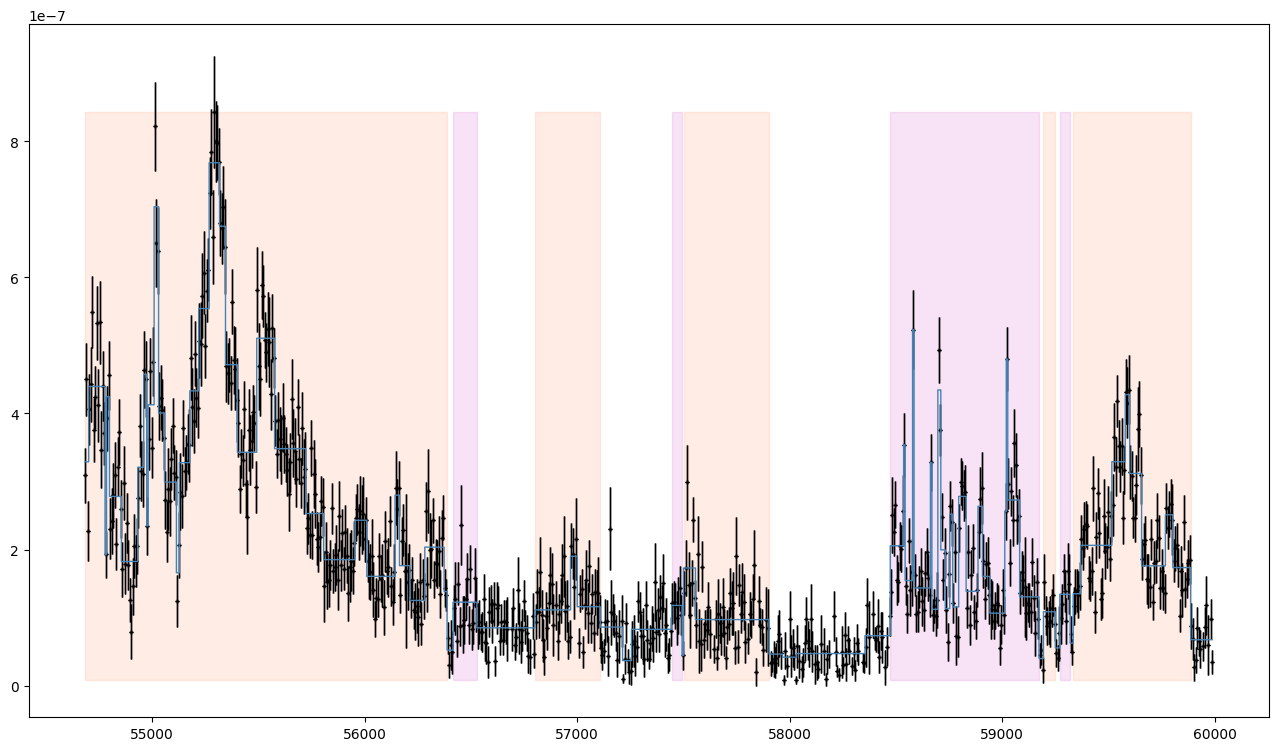

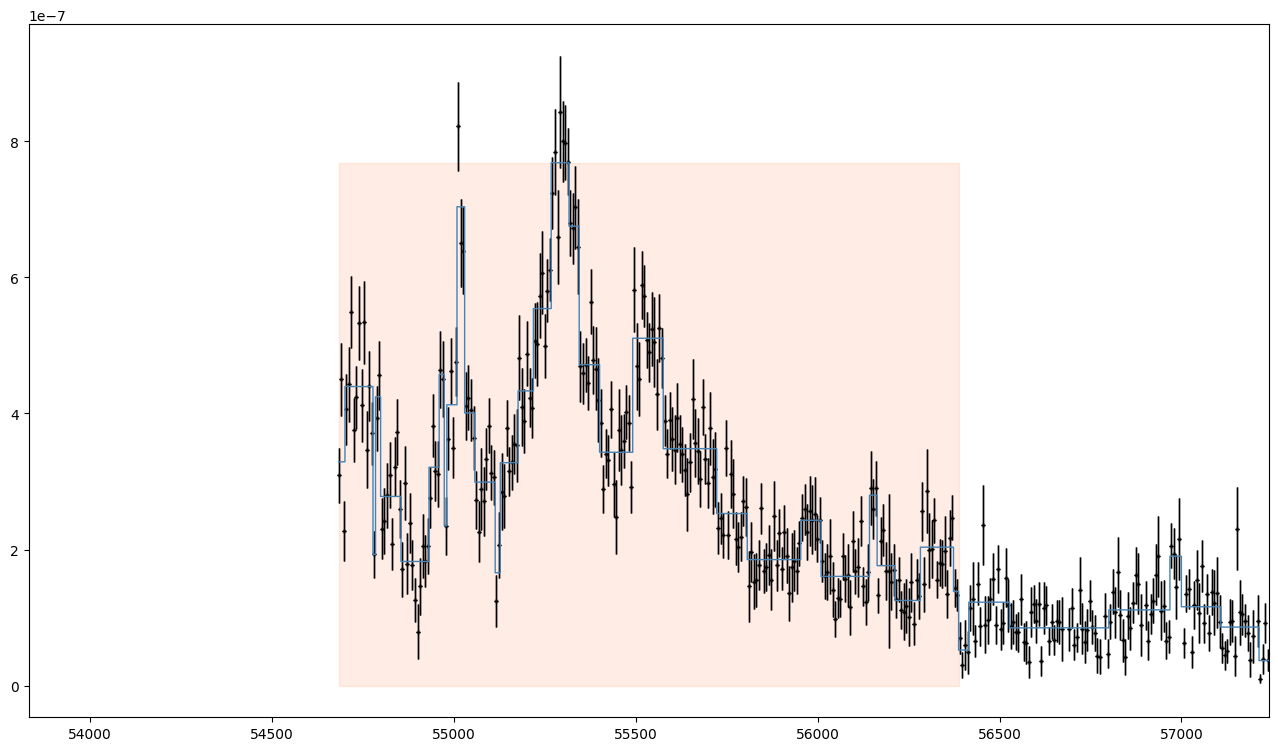

In [ ]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [ ]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


In [ ]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      